# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

## Problem 4
Now let's move to the next stage:
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right)&=\left(f, \chi_{h}\right) \\
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) \\
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}c_{h}\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right) &=0 \\
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right) &=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
\end{aligned}
$$
where 
$$
c_{h}\left(\phi_{h}, \psi_{h}\right):=\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n}\left(\phi_{h} \cdot t\right), \psi_{h} \cdot t\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\phi_{h} \cdot t, \partial_{n}\left(\psi_{h} \cdot t\right)\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\phi_{h} \cdot t, \psi_{h} \cdot t\right)_{F}
$$

In [1]:
from skfem import *
import numpy as np
from utils import solver_iter_krylov, solver_iter_pyamg, solver_iter_mgcg
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod, div, curl
from scipy.sparse.linalg import LinearOperator, minres
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
from skfem.visuals.matplotlib import draw, plot
import scipy.sparse.linalg as spl
from scipy.sparse import bmat
from skfem.visuals.matplotlib import draw, plot
import datetime
import pandas as pd
import sys
import time

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

## Errors

In [2]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

## Element CR

In [3]:
class ElementTriCR(ElementH1):
    
    facet_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[.5, 0.], [.5, .5], [0., .5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * y
            dphi = np.array([0. * x, -2. + 0. * y])
        elif i == 1:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        elif i == 2:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        else:
            self._index_error()
        return phi, dphi

## Forms for decoupled equations

### First two Poisson equations

In [4]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def zv_load(u, v, w):
    '''
    for 5.7a
    '''
    return dot(curl(u), curl(v))

### Stokes equation

In [5]:
@BilinearForm
def phipsi_load1(u, v, w):
    '''
    for 5.7b $(phi, psi)$
    '''
    return dot(u, v)

@BilinearForm
def phipsi_load2(u, v, w):
    '''
    for 5.7b $(Laplace_phi, Laplace_psi)$
    '''
    return ddot(grad(u), grad(v))

@BilinearForm
def phipsi_load3(u, v, w):
    '''
    for 5.7b $(div_phi, p)$
    '''
    return div(u) * v

@BilinearForm
def zpsi_load(u, v, w):
    '''
    for 5.7b $(curl_z, psi)$
    '''
    return dot(curl(u), v)

@BilinearForm
def phiq_load(u, v, w):
    '''
    for 5.7c $(div_phi, q)$
    '''
    return div(u) * v

@BilinearForm
def mass(u, v, w):
    '''
    for 5.7c C
    '''
    return u * v * 1e-6

### Imposing penalty

In [232]:
@BilinearForm
def penalty_1(u, v, w):
    w_t = np.array([-w.n[1], w.n[0]])
    return -ddot(d(u), prod(w_t, w.n)) * dot(v, w_t)


@BilinearForm
def penalty_2(u, v, w):
    w_t = np.array([-w.n[1], w.n[0]])
    return -ddot(d(v), prod(w_t, w.n)) * dot(u, w_t)


@BilinearForm
def penalty_3(u, v, w):
    w_t = np.array([-w.n[1], w.n[0]])
    return (sigma / w.h) * dot(u, w_t) * dot(v, w_t)

### Setting boundary conditions for
$$\int_{F} v \cdot n \mathrm{d} s=0$$

In [233]:
def normal_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions for u^n
    ----------------
    Note: u^1 here stands for the first component of u and u^2 for the second
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].facet['u^1'], dofs['right'].facet['u^1'],
                        dofs['top'].facet['u^2'], dofs['buttom'].facet['u^2']))
    return D

### The last Poisson equation

In [234]:
@BilinearForm
def phichi_load(u, v, w):
    '''
    for 5.7d $(phi, curl_chi)$
    '''
    return dot(u, curl(v))

@BilinearForm
def uchi_load(u, v, w):
    '''
    for 5.7d $(curl_u, curl_chi)$
    '''
    return dot(curl(u), curl(v))

# Error Estimating

## Solver

In [235]:
def solve_problem4(m, element_type='P1', solver_type='pcg', tol=1e-8):
    '''
    solver for decoupled problem2
    without modifying solver
    only for testing convergence
    '''
    
    # equation 1
    
    if element_type == 'P1':
        element1 = ElementTriP1()
    elif element_type == 'P2':
        element1 = ElementTriP2()
    else:
        raise Exception("Element not supported")
        
    basis1 = InteriorBasis(m, element1, intorder=intorder)

    K1 = asm(laplace, basis1)
    f1 = asm(f_load, basis1)

    wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
   
    # equation 2
    
    element2 = ElementTriMorley()
    basis2 = InteriorBasis(m, element2, intorder=intorder)

    K2 = asm(zv_load, basis2)
    f2 = asm(laplace, basis1, basis2) * wh

    zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    # equation 3
    
    element3 = {'phi': ElementVectorH1(ElementTriCR()), 'p': ElementTriP0()}
    basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  
    
    fbasis = FacetBasis(m, element3['phi'], intorder=intorder)
    
    p1 = asm(penalty_1, fbasis)
    p2 = asm(penalty_2, fbasis)
    p3 = asm(penalty_3, fbasis)
    P = p1 + p2 + p3
    
    A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * (asm(phipsi_load2, basis3['phi']) + P) 
    B = asm(phiq_load, basis3['phi'], basis3['p'])
    C = asm(mass, basis3['p'])
    
    F1 = asm(zpsi_load, basis2, basis3['phi']) * zh
    f3 = np.concatenate([F1, np.zeros(B.shape[0])])
    K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')
    
    # imposing boundary condition for normal conponent of phi
    
    phip = solve(*condense(K3, f3, D=normal_boundary(basis3['phi'])), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    
    # phip = solve(*condense(K3, f3, D=m.boundary_nodes()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    phih, ph = np.split(phip, [A.shape[0]])
    # phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    
    # equation 4
    
    element4 = ElementTriMorley()
    basis4 = InteriorBasis(m, element4, intorder=intorder)

    K4 = asm(uchi_load, basis4)
    f4 = asm(phichi_load, basis3['phi'], basis4) * phih
    
    uh = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    return uh, {'u' :basis4}

In [13]:
def solve_problem4(m, element_type='P1', solver_type='pcg', tol=1e-8):
    '''
    solver for decoupled problem2
    without modifying solver
    only for testing convergence
    '''
    
    # equation 1
    
    if element_type == 'P1':
        element1 = ElementTriP1()
    elif element_type == 'P2':
        element1 = ElementTriP2()
    else:
        raise Exception("Element not supported")
        
    basis1 = InteriorBasis(m, element1, intorder=intorder)

    K1 = asm(laplace, basis1)
    f1 = asm(f_load, basis1)

    wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
   
    # equation 2
    
    element2 = ElementTriMorley()
    basis2 = InteriorBasis(m, element2, intorder=intorder)

    K2 = asm(zv_load, basis2)
    f2 = asm(laplace, basis1, basis2) * wh

    zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    # equation 3
    
    element3 = {'phi': ElementVectorH1(ElementTriCR()), 'p': ElementTriP0()}
    basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  
    
    fbasis = FacetBasis(m, element3['phi'], intorder=intorder)
    
    p1 = asm(penalty_1, fbasis)
    p2 = asm(penalty_2, fbasis)
    p3 = asm(penalty_3, fbasis)
    P = p1 + p2 + p3
    
    A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * (asm(phipsi_load2, basis3['phi']) + P) 
    B = asm(phiq_load, basis3['phi'], basis3['p'])
    C = asm(mass, basis3['p'])
    
    F1 = asm(zpsi_load, basis2, basis3['phi']) * zh
    f3 = np.concatenate([F1, np.zeros(B.shape[0])])
    K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')
    
    # imposing boundary condition for normal conponent of phi
    
    phip = solve(*condense(K3, f3, D=normal_boundary(basis3['phi'])), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    
    # phip = solve(*condense(K3, f3, D=m.boundary_nodes()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    phih, ph = np.split(phip, [A.shape[0]])
    # phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    
    # equation 4
    
    element4 = ElementTriMorley()
    basis4 = InteriorBasis(m, element4, intorder=intorder)

    K4 = asm(uchi_load, basis4)
    f4 = asm(phichi_load, basis3['phi'], basis4) * phih
    
    uh = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    return uh, {'u' :basis4}

## Testing convergence

In [242]:
tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 6
epsilon_range = 5
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = True
example = 'ex3'

In [243]:
if example == 'ex1':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                            ((sin(pix))**2))
        llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                            sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
        return (epsilon**2 * llu - lu) * v


    def exact_u(x, y):
        return (sin(pi * x) * sin(pi * y))**2


    def dexact_u(x, y):
        dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
        duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
        return dux, duy


    def ddexact(x, y):
        duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
            pi * x)**2 * sin(pi * y)**2
        duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
            pi * y)
        duyx = duxy
        duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
            pi * y)**2 * sin(pi * x)**2
        return duxx, duxy, duyx, duyy

elif example == 'ex2':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        x = w.x[0]
        y = w.x[1]
        return (
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            (12 * y + ep *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) -
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - ep**2 *
            (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
                (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                    (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                    (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                    (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - 2 *
            (12 * y + ep *
            ((exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) *
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


    def exact_u(x, y):
        return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                                (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                                (3 * exp(-1 / ep) + 3) /
                                                (exp(-1 / ep) - 1) -
                                                ((2 * y - 1) *
                                                (exp(-1 / ep) - 1)) /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))


    def dexact_u(x, y):
        dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
            (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                    (3 / (exp(-1 / ep) - 1) - 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        return dux, duy


    def ddexact(x, y):
        duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                (exp(-1 / ep) + 2 * ep *
                (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        duyx = duxy
        duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (12 * y + ep *
                                        ((exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                        (exp((y - 1) / ep) *
                                            (3 / (exp(-1 / ep) - 1) - 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2))
        return duxx, duxy, duyx, duyy

elif example == 'ex3':

    @LinearForm
    def f_load(v, w):
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        return (2 * pi**2 * sin(pix) * sin(piy)) * v


    def exact_u(x, y):
        return sin(pi * x) * sin(pi * y)


    def dexact_u(x, y):
        dux = pi * cos(pi * x) * sin(pi * y)
        duy = pi * cos(pi * y) * sin(pi * x)
        return dux, duy


    def ddexact(x, y):
        duxx = -pi**2 * sin(pi * x) * sin(pi * y)
        duxy = pi * cos(pi * x) * pi * cos(pi * y)
        duyx = duxy
        duyy = -pi**2 * sin(pi * y) * sin(pi * x)
        return duxx, duxy, duyx, duyy

else:
    raise Exception('Example not supported')

In [241]:
df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2) * (1 - zero_ep)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()
    
    for i in range(1, refine_time+1):
        m.refine()
        uh0, basis = solve_problem4(m, element_type, solver_type, tol=tol)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
#         print(
#             '2^-' + str(i + 2), ' {:.5f}  {:.5f}  {:.5f}  {:.5f}'.format(
#                 L2s[i + 1], H1s[i + 1],
#                 H2s[i + 1],
#                 epus[i + 1]))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  0.00  0.00  0.01  0.01
2^-3  -0.00  0.00  0.00  0.00
2^-4  -0.00  -0.00  0.00  0.00
2^-5  -0.00  -0.00  -0.00  0.00
2^-6  -0.00  -0.00  -0.00  -0.00
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.72  0.81  -0.19  0.70
2^-3  1.49  0.65  -0.44  0.56
2^-4  1.01  0.52  -0.42  0.39
2^-5  -0.14  0.39  -0.30  0.19
2^-6  -0.40  0.13  -0.12  0.03
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.74  0.81  -0.20  0.71
2^-3  1.57  0.65  -0.46  0.60
2^-4  1.51  0.55  -0.49  0.52
2^-5  1.51  0.52  -0.49  0.50
2^-6  1.50  0.51  -0.50  0.50
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  1.74  0.81  -0.20  0.71
2^-3  1.57  0.65  -0.46  0.60
2^-4  1.51  0.55  -0.49  0.52
2^-5  1.51  0.52  -0.49  0.50
2^-6  1.50  0.51  -0.50  0.50
epsilon = 1e-08
  h    L2u   H1u   H2u   epu
2^-2  1.74  0.81  -0.20  0.71
2^-3  1.57  0.65  -0.46  0.60
2^-4  1.51  0.55  -0.49  0.52
2^-5  1.51  0.52  -0.49  0.50
2^-6  1.50  0.51  -0.50  0.50


# Single test

In [269]:
epsilon = 1e-8
ep = epsilon

In [322]:
%%time

m = MeshTri()
m.refine(2)

# equation 1

if element_type == 'P1':
    element1 = ElementTriP1()
elif element_type == 'P2':
    element1 = ElementTriP2()
else:
    raise Exception("Element not supported")

basis1 = InteriorBasis(m, element1, intorder=intorder)

K1 = asm(laplace, basis1)
f1 = asm(f_load, basis1)

wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

# equation 2

element2 = ElementTriMorley()
basis2 = InteriorBasis(m, element2, intorder=intorder)

K2 = asm(zv_load, basis2)
f2 = asm(laplace, basis1, basis2) * wh

zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

Wall time: 22.9 ms


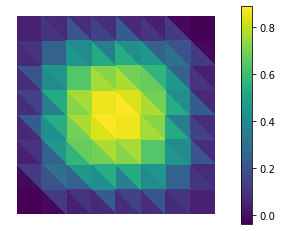

In [323]:
plot(basis2, zh, colorbar=True)

In [348]:
# equation 3

element3 = {'phi': ElementVectorH1(ElementTriCR()), 'p': ElementTriP0()}
basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  

fbasis = FacetBasis(m, element3['phi'], intorder=intorder)

p1 = asm(penalty_1, fbasis)
p2 = asm(penalty_2, fbasis)
p3 = asm(penalty_3, fbasis)
P = p1 + p2 + p3

A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi']) + epsilon**2 * P
B = asm(phiq_load, basis3['phi'], basis3['p'])
C = asm(mass, basis3['p'])

F1 = asm(zpsi_load, basis2, basis3['phi']) * zh
f3 = np.concatenate([F1, np.zeros(B.shape[0])])
K3 = bmat([[A, -B.T], [-B, C]], 'csr')

# imposing boundary condition for normal conponent of phi

phip = solve(*condense(K3, f3, np.ones_like(f3)*0, D=normal_boundary(basis3['phi'])), solver=solver_iter_krylov(minres, tol=1e-13))

phih, ph = np.split(phip, [A.shape[0]])

# phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
# phih, ph = np.split(phip, [A.shape[0]])

In [378]:
phip, _ = minres(K3, f3, tol=1e-13)
phih, ph = np.split(phip, [A.shape[0]])

In [379]:
normal_boundary(basis3['phi'])

array([ 2, 10, 28, 30,  8, 16, 48, 50, 15, 19, 57, 59,  1,  5, 21, 23],
      dtype=int64)

In [380]:
phip.shape

(144,)

In [381]:
144/3

48.0

In [382]:
condense(K3, f3, np.ones_like(f3)*100, D=normal_boundary(basis3['phi']))[0]

<128x128 sparse matrix of type '<class 'numpy.float64'>'
	with 672 stored elements in Compressed Sparse Row format>

In [383]:
testbasis = InteriorBasis(m, ElementTriCR(), intorder=intorder)

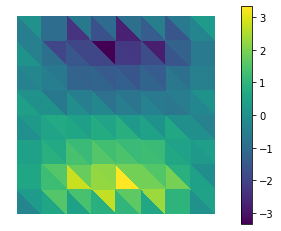

In [384]:
plot(testbasis, phih[::2], colorbar=True)

In [385]:
phih.shape

(112,)

In [386]:
locx = fbasis.doflocs[0][::2]
locy = fbasis.doflocs[1][::2]

In [387]:
phih1 = phih[::2]
phih2 = phih[1::2]

In [388]:
sum(locx == 0)

4

phih1

In [389]:
phih1[locx == 0]

array([ 2.20335908e-16, -8.30568370e-16,  3.69407320e-16,  1.46474398e-16])

In [390]:
phih1[locx == 1]

array([ 9.38871994e-16,  2.06564914e-16,  1.40098257e-15, -1.34186219e-16])

In [391]:
phih1[locy == 0]

array([2.34106903e-16, 6.92862065e-16, 1.38272175e-15, 1.88012718e-15])

In [392]:
phih1[locy == 1]

array([-9.84064962e-16,  3.85587840e-16, -1.50315271e-15, -1.00509644e-15])

phih2

In [393]:
phih2[locx == 0]

array([-2.20335908e-16, -9.94106441e-16, -1.42106417e-15, -1.72477803e-15])

In [394]:
phih2[locx == 1]

array([ 8.43484253e-16, -2.06564914e-16,  1.59611126e-15,  5.30399421e-16])

In [395]:
phih2[locy == 0]

array([-2.34106903e-16,  5.00269568e-16, -4.47915659e-16, -2.17908181e-16])

In [396]:
phih2[locy == 1]

array([-2.51746113e-16, -3.85587840e-16, -5.80795693e-16, -1.04985787e-16])

In [342]:
testbasis = InteriorBasis(m, ElementTriCR(), intorder=intorder)

In [343]:
# equation 4

element4 = ElementTriMorley()
basis4 = InteriorBasis(m, element4, intorder=intorder)

K4 = asm(uchi_load, basis4)
f4 = asm(phichi_load, basis3['phi'], basis4) * phih

uh = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))